In [68]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_regression

import sys
import os

from npeet import entropy_estimators as ee

In [69]:
# open hdf5
path = "../DATA/contribution_22_full.hdf5"
ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 329MB
Dimensions:                 (wavelength: 52, sample: 91392, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 731kB 0 1 2 3 ... 91389 91390 91391
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 38MB ...
    noise                   (sample, wavelength) float64 38MB ...
    planet_temp_k           (sample) float64 731kB ...
    log_H2O                 (sample) float64 731kB ...
    log_CO2                 (sample) float64 731kB ...
    ...                      ...
    planet_radius_m         (sample) float64 731kB ...
    planet_surface_gravity  (sample) float64 731kB ...
    valid_quartiles         (sample) bool 91kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 13MB ...
    contributions           (sample, species, wavelength) float64 190MB ...
    clean_forward_model     (sample, wavelength) float64 38MB ...

In [70]:
ipath = "../DATA/train_validation_indecies.hdf5"
ids = xr.open_dataset(ipath)
ids

<xarray.Dataset> Size: 731kB
Dimensions:    (train_samples: 73113, val_samples: 18279)
Dimensions without coordinates: train_samples, val_samples
Data variables:
    train_idx  (train_samples) int64 585kB ...
    val_idx    (val_samples) int64 146kB ...

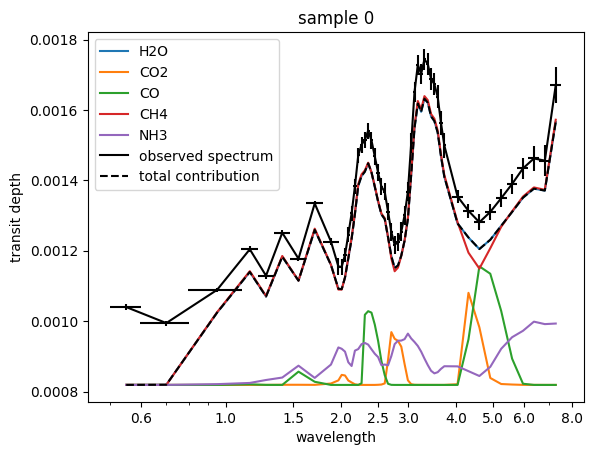

In [71]:
i = 0
all_species = ds.species.values[1:]

plt.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2', 'CO', 'CH4', 'NH3']
                    ).values.T, label=['H2O', 'CO2', 'CO', 'CH4', 'NH3'])

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()

In [72]:
label_names = ['log_H2O', 'log_CO2']
labels = ds[label_names]
labels_np = labels.to_array().values.T

labels_np.shape

(91392, 2)

In [73]:
spectrum_np = ds['spectrum'].values
spectrum_np.shape

(91392, 52)

In [74]:
noise_np = ds['noise'].values
h2o_np = ds['contributions'].sel(species='H2O').values
co2_np = ds['contributions'].sel(species='CO2').values
noise_np.shape

(91392, 52)

In [75]:
train_spectra = spectrum_np[ids['train_idx']]
train_labels = labels_np[ids['train_idx']]
train_noise = noise_np[ids['train_idx']]
train_h2o = h2o_np[ids['train_idx']]
train_co2 = co2_np[ids['train_idx']]
train_spectra.shape, train_labels.shape, train_noise.shape, train_h2o.shape, train_co2.shape

((73113, 52), (73113, 2), (73113, 52), (73113, 52), (73113, 52))

In [76]:
# split train into train and test
train_spectra, test_spectra, train_labels, test_labels, train_noise, test_noise, train_h2o, test_h2o, train_co2, test_co2 = train_test_split(train_spectra, train_labels, train_noise, train_h2o, train_co2, test_size=0.2, random_state=42)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}
train_noise: {train_noise.shape}
train_h2o: {train_h2o.shape}
train_co2: {train_co2.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
test_noise: {test_noise.shape}
test_h2o: {test_h2o.shape}
test_co2: {test_co2.shape}
""")


train_spectra: (58490, 52)
train_labels: (58490, 2)
train_noise: (58490, 52)
train_h2o: (58490, 52)
train_co2: (58490, 52)

test_spectra: (14623, 52)
test_labels: (14623, 2)
test_noise: (14623, 52)
test_h2o: (14623, 52)
test_co2: (14623, 52)



In [77]:
class z_normaliser():
    def __init__(self):
        self.mean = None
        self.std = None
    
        
    def normalise(self, data, set=False):
        if set:
            self.mean = np.mean(data, axis=0)
            self.std = np.std(data, axis=0)

        return (data - self.mean) / self.std
    
    def denormalise(self, data):  
        return data * self.std + self.mean

In [78]:
class minmax_normaliser():
    def __init__(self):
        self.min = None
        self.max = None
    
        
    def normalise(self, data, set=False):
        if set:
            self.min = np.min(data, axis=0)
            self.max = np.max(data, axis=0)

        return (data - self.min) / (self.max - self.min)
    
    def denormalise(self, data):  
        return data * (self.max - self.min) + self.min

In [79]:
class log_normaliser():
    def __init__(self):
        self.min = None  # Stores the min of log-transformed data
        self.max = None  # Stores the max of log-transformed data
    
    def normalise(self, data, set=False):
        data_log = np.log(np.abs(data) + np.finfo(float).eps)
        if set:
            self.min = np.min(data_log, axis=0)
            self.max = np.max(data_log, axis=0)
        return (data_log - self.min) / (self.max - self.min)
    
    def denormalise(self, data):
        data_log = data * (self.max - self.min) + self.min
        return np.exp(data_log) - np.finfo(float).eps


In [80]:
normaliser_class = minmax_normaliser
spectra_normaliser_class = log_normaliser

In [81]:
labels_normaliser = normaliser_class()
spectra_normaliser = spectra_normaliser_class()

train_labels_normalised = labels_normaliser.normalise(train_labels, set=True)
train_spectra_normalised = spectra_normaliser.normalise(train_spectra, set=True)

test_labels_normalised = labels_normaliser.normalise(test_labels)
test_spectra_normalised = spectra_normaliser.normalise(test_spectra)


In [82]:
# create a model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [83]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()

        self.fc1 = nn.Linear(52, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [84]:
model = NetA()

# create a loss function
criterion = nn.MSELoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #lr=0.0005)

# create a data loader
batch_size = 128
train_dataset = TensorDataset(torch.Tensor(train_spectra_normalised), torch.Tensor(train_labels_normalised))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [85]:
# load the best model 
model.load_state_dict(torch.load('modela.pt'))

<All keys matched successfully>

In [86]:
# make predictions
model.eval()

with torch.no_grad():
    predictions = model(torch.Tensor(test_spectra_normalised))

predictions = labels_normaliser.denormalise(predictions.numpy())

print(f'len(predictions): {predictions.shape}')
print(f'len(test_labels): {test_labels.shape}')

len(predictions): (14623, 2)
len(test_labels): (14623, 2)


## Information Theory

In [87]:
# Assume test_spectra and observation_uncertainty are already defined with shapes (n_samples, 52)
n_samples, n_wavelengths = train_spectra.shape  # n_wavelengths should be 52
n_replicates = 5

# Preallocate the output array with shape:
# (n_samples, 52 (spectrum features), 100 (replicates))
augmented_spectra = np.empty((n_samples, n_wavelengths, n_replicates))

# Reshape test_spectra for broadcasting to (n_samples, 52, 100)
base_spectra_expanded = np.expand_dims(train_spectra, axis=(2))
base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_replicates))

# Generate noise for all perturbations and replicates simultaneously
noise = np.random.normal(
    loc=0.0,
    scale=np.expand_dims(train_noise, axis=(2)),
    size=(n_samples, n_wavelengths, n_replicates)
)

augmented_spectra = base_spectra_expanded + noise 

print("Noisy spectra generated with shape:", augmented_spectra.shape)

Noisy spectra generated with shape: (58490, 52, 5)


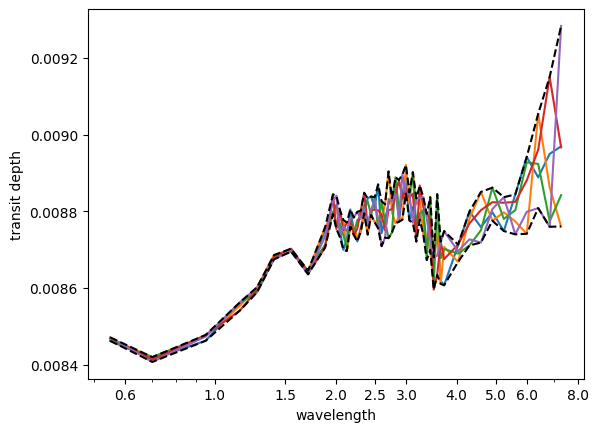

In [88]:
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :],label='mean')
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :].min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :].max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [89]:
# normalise the spectra
aug_spectra_normaliser = spectra_normaliser_class()
augmented_spectra_normalised = aug_spectra_normaliser.normalise(augmented_spectra, set=True)

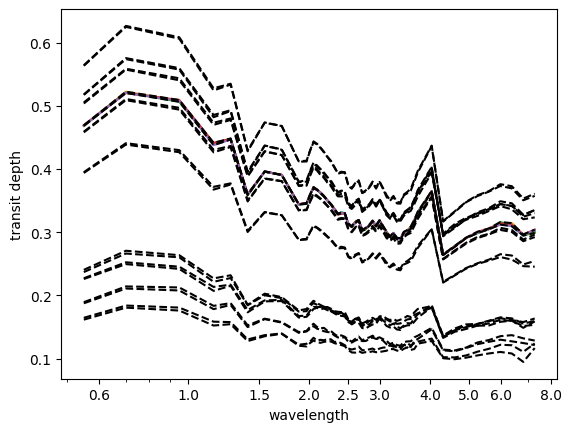

In [90]:
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[0, :, :],label='mean')
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[:10, :, :].min(axis=2).T, 'k--',label='min')
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[:10, :, :].max(axis=2).T, "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

### treat abundancies as independant
not technically correct, but should be a good starting point

In [91]:
# delete the variable results
# del results

In [92]:
# # Reshape augmented spectra and labels for MI computation
# augmented_spectra_flat = augmented_spectra_normalised.reshape(-1, n_wavelengths)  # (n_samples * 100, 52)
# labels_replicated = np.repeat(test_labels_normalised, n_replicates, axis=0)       # (n_samples * 100, 2)

# # Preallocate results
# if 'results' not in locals(): # Only preallocate if it doesn't exist, that way it won't be overwritten
#     results = np.zeros((n_wavelengths, 2))

#     # Compute MI for each label (H2O and CO2)
#     for label_idx in range(2):  # 0: H2O, 1: CO2
#         mi = mutual_info_regression(augmented_spectra_flat, labels_replicated[:, label_idx], random_state=42)
        
#         # Assign MI values to results array
#         results[:, label_idx] = mi
# else:
#     print("Results already exist. Skipping computation.")

# print("Results shape:", results.shape)  # (n_samples, 52, 2)


In [93]:
# i = 0
# all_species = ds.species.values[1:]

# fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ax_mi = ax[1]
# ax = ax[0]

# ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


# ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
# ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


# ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# # ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')
# # ax_shap.plot(ds['wavelength'], joint_shap_values[i], 'k-',label='SHAP total')

# ax_mi.plot(ds['wavelength'], results[:, 0], label=r'$X_i$ contrib to H2O')
# ax_mi.plot(ds['wavelength'], results[:, 1], label=r'$X_i$ contrib to CO2')


# ax_mi.set_xlabel('wavelength')
# ax.set_ylabel('transit depth')
# ax_mi.set_ylabel('Mutual Information')

# ax.set_xscale('log')
# ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
# ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# fig.suptitle(f'sample {i} for reference, MI is sample independent')
# ax_mi.legend(loc='lower left')
# ax.legend()

### calculate the best H2O _**given**_ a value for CO2
using CMI


In [94]:
x = [[1.3],[3.7],[5.1],[2.4],[3.4]]
y = [[1.5],[3.32],[5.3],[2.3],[3.3]]
ee.mi(x,y)

np.float64(0.16831442143704642)

In [95]:
# This prints the mutual information between column 5 and 9, conditioned on columns 15 and 17.
# You can also use the function shuffle_test to return confidence intervals for any estimator.
# Shuffle_test returns the mean CMI under the null hypothesis (CMI=0), and 95% confidence intervals,
# estimated using 1000 random permutations of the data. Note that we converted the numpy arrays to lists!
# The current version really works only on python lists (lists of lists actually, as in the first example.

my_data = np.random.rand(100,20)

x = my_data[:,[5]].tolist()
y = my_data[:,[9]].tolist()
z = my_data[:,[15,17]].tolist()
print(ee.cmi(x, y, z))
print(ee.shuffle_test(ee.cmi, x, y, z, ci=0.95, ns=1000))

-0.009084442458097574
(np.float64(-0.005006821397303625), (np.float64(-0.12451132891543167), np.float64(0.12359095449568691)))


In [96]:
# takes 22 min to run!! 

if os.path.exists('results_mi.npy'):
    results_mi = np.load('results_mi.npy')

else:
    input("This will take a long time to run, are you sure you want to continue?")

    # Reshape augmented spectra for MI computation
    augmented_spectra_flat = augmented_spectra_normalised.reshape(-1, n_wavelengths)  # Shape: (n_samples * 100, 52)
    joint_labels_replicated = np.repeat(train_labels_normalised, n_replicates, axis=0)  # Shape: (n_samples * 100, 2)

    print("Shapes for MI computation:")
    print(f'N wavelengths: {n_wavelengths}')
    print(f'N replicates: {n_replicates}')

    print(f'train_labels_normalised: {train_labels_normalised.shape}')
    print(f'augmented_spectra_normalised: {augmented_spectra_normalised.shape}')
    print("Augmented spectra:", augmented_spectra_flat.shape)
    print("Joint labels:", joint_labels_replicated.shape)

    # Preallocate results for CMI
    results_mi = np.zeros((n_wavelengths, 2))  

    for label_idx in range(2):  # 0: H2O, 1: CO2

        for wavelength_idx in range(n_wavelengths):
            print(f'Label {label_idx}, Wavelength {wavelength_idx}')

            # Extract feature for this wavelength
            feature = augmented_spectra_flat[:, wavelength_idx]  # Shape: (n_samples * 100,)
            
            # Current label and the other label
            current_label = joint_labels_replicated[:, label_idx]
            
            # Compute conditional MI
            # (This requires a custom implementation or using a library that supports CMI)

            cmi = ee.mi(feature.tolist(), current_label.tolist())
            
            
            results_mi[wavelength_idx, label_idx] = cmi

    print("Results shape (MI):", results_mi.shape)  # (n_samples, 52, 2)
    np.save('results_mi.npy', results_mi)


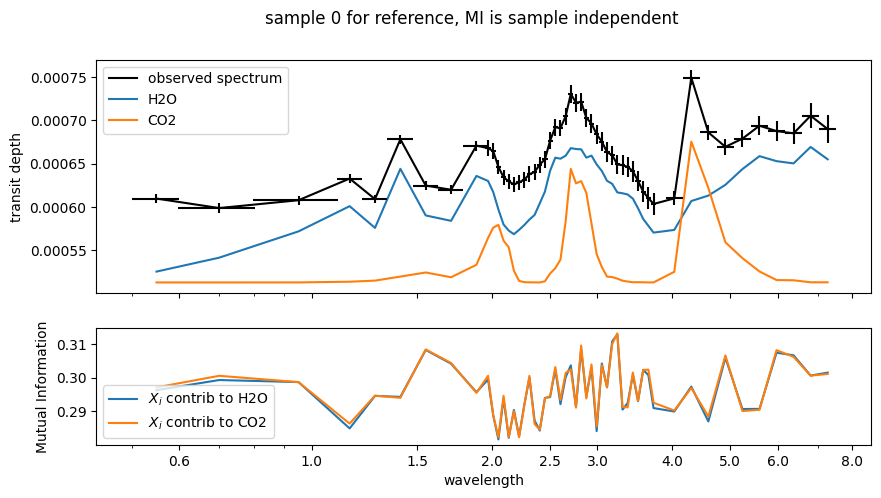

In [97]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_mi = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')
# ax_shap.plot(ds['wavelength'], joint_shap_values[i], 'k-',label='SHAP total')

ax_mi.plot(ds['wavelength'], results_mi[:, 0], label=r'$X_i$ contrib to H2O')
ax_mi.plot(ds['wavelength'], results_mi[:, 1], label=r'$X_i$ contrib to CO2')


ax_mi.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_mi.set_ylabel('Mutual Information')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i} for reference, MI is sample independent')
ax_mi.legend(loc='lower left')
ax.legend()

### how about given the other value?

In [98]:
# takes 22 min to run!! 

if os.path.exists('results_cmi.npy'):
    results_cmi = np.load('results_cmi.npy')

else:
    input("This will take a long time to run, are you sure you want to continue?")

    # Reshape augmented spectra for MI computation
    augmented_spectra_flat = augmented_spectra_normalised.reshape(-1, n_wavelengths)  # Shape: (n_samples * 100, 52)
    joint_labels_replicated = np.repeat(train_labels_normalised, n_replicates, axis=0)  # Shape: (n_samples * 100, 2)

    print("Shapes for MI computation:")
    print(f'N wavelengths: {n_wavelengths}')
    print(f'N replicates: {n_replicates}')

    print(f'train_labels_normalised: {train_labels_normalised.shape}')
    print(f'augmented_spectra_normalised: {augmented_spectra_normalised.shape}')
    print("Augmented spectra:", augmented_spectra_flat.shape)
    print("Joint labels:", joint_labels_replicated.shape)

    # Preallocate results for CMI
    results_cmi = np.zeros((n_wavelengths, 2))  

    for label_idx in range(2):  # 0: H2O, 1: CO2
        other_label_idx = 1 - label_idx

        for wavelength_idx in range(n_wavelengths):
            print(f'Label {label_idx}, Wavelength {wavelength_idx}')

            # Extract feature for this wavelength
            feature = augmented_spectra_flat[:, wavelength_idx]  # Shape: (n_samples * 100,)
            
            # Current label and the other label
            current_label = joint_labels_replicated[:, label_idx]
            conditioned_label = joint_labels_replicated[:, other_label_idx]
            
            # Compute conditional MI
            # (This requires a custom implementation or using a library that supports CMI)

            cmi = ee.mi(feature.tolist(), current_label.tolist(), conditioned_label.tolist())
            
            
            results_cmi[wavelength_idx, label_idx] = cmi

    print("Results shape (Conditional MI):", results_cmi.shape)  # (n_samples, 52, 2)
    np.save('results_cmi.npy', results_cmi)


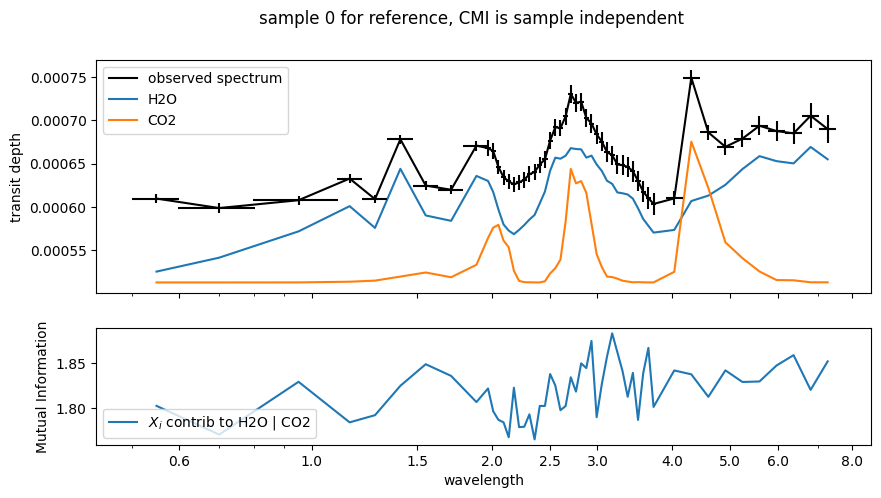

In [99]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_mi = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')


ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')
# ax_shap.plot(ds['wavelength'], joint_shap_values[i], 'k-',label='SHAP total')

ax_mi.plot(ds['wavelength'], results_cmi[:, 0], label=r'$X_i$ contrib to H2O | CO2')
# ax_mi.plot(ds['wavelength'], results_cmi[:, 1], label=r'$X_i$ contrib to CO2 | H2O')


ax_mi.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_mi.set_ylabel('Mutual Information')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i} for reference, CMI is sample independent')
ax_mi.legend(loc='lower left')
ax.legend()

### how about iteratively

In [ ]:
# takes 22 min to run!! 

if os.path.exists('results_mi_iter.npy'):
    results_mi_iter = np.load('results_mi_iter.npy')

else:
    input("This will take a long time to run, are you sure you want to continue?")

    # Reshape augmented spectra for MI computation
    augmented_spectra_flat = augmented_spectra_normalised.reshape(-1, n_wavelengths)  # Shape: (n_samples * 100, 52)
    joint_labels_replicated = np.repeat(train_labels_normalised, n_replicates, axis=0)  # Shape: (n_samples * 100, 2)

    print("Shapes for MI computation:")
    print(f'N wavelengths: {n_wavelengths}')
    print(f'N replicates: {n_replicates}')

    print(f'train_labels_normalised: {train_labels_normalised.shape}')
    print(f'augmented_spectra_normalised: {augmented_spectra_normalised.shape}')
    print("Augmented spectra:", augmented_spectra_flat.shape)
    print("Joint labels:", joint_labels_replicated.shape)

    # Preallocate results for CMI, shape (n_wavelengths (iterations), n_wavelengths (wavelengths), 2 (species))
    results_mi_iter = np.zeros((n_wavelengths, n_wavelengths, 2))  

    # Preallocate the best wavelength choice array, shape (n_wavelengths, 2)
    best_wavelength_choice = np.zeros((n_wavelengths, 2))

    for j in range(n_wavelengths):

        for label_idx in range(2):  # 0: H2O, 1: CO2

            for wavelength_idx in range(n_wavelengths):
                # print(f'Label {label_idx}, Wavelength {wavelength_idx}')

                # Extract feature for this wavelength
                feature = augmented_spectra_flat[:, wavelength_idx]  # Shape: (n_samples * 100,)
                
                # Current label and the other label
                current_label = joint_labels_replicated[:, label_idx]

                chosen_wavelengths = best_wavelength_choice[:j, label_idx].astype(int)

                givens = augmented_spectra_flat[:, chosen_wavelengths]
                
                # Compute conditional MI
                if j == 0:
                    cmi = ee.mi(feature.tolist(), current_label.tolist())
                else:
                    cmi = ee.mi(feature.tolist(), current_label.tolist(), givens.tolist())
                
                results_mi_iter[j, wavelength_idx, label_idx] = cmi

        # Find the best wavelength choice for each label
        best_wavelength_choice[j, 0] = np.argmax(results_mi_iter[j, :, 0])
        best_wavelength_choice[j, 1] = np.argmax(results_mi_iter[j, :, 1])

        # plot progress
        plt.plot(ds['wavelength'], results_mi_iter[j, :, 0], label=r'$X_i$ contrib to H2O')
        plt.plot(ds['wavelength'], results_mi_iter[j, :, 1], label=r'$X_i$ contrib to CO2')
        h2o = best_wavelength_choice[:j+1,0].astype(int)
        co2 = best_wavelength_choice[:j+1,1].astype(int)

        for h in h2o:
            plt.axvline(ds['wavelength'].isel(wavelength=h), color='lightblue', linestyle='--')
        for c in co2:
            plt.axvline(ds['wavelength'].isel(wavelength=c), color='orange', linestyle='--')

        plt.xlabel('wavelength')
        plt.ylabel('Mutual Information')
        plt.title(f'Iteration {j}')

        axs = plt.gca()
        axs.set_xscale('log')
        axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
        axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

        plt.savefig(f'iter.png')
        plt.close()

        np.save('results_mi_iter.npy', results_mi_iter)
        np.save('best_wavelength_choice.npy', best_wavelength_choice)
        print(f'-- Iteration {j} --')
        print('h2o', h2o)
        print('co2', co2)

    print("Results shape (MI):", results_mi.shape)  # (n_samples, 52, 2)
    np.save('results_mi_iter.npy', results_mi_iter)


Shapes for MI computation:
N wavelengths: 52
N replicates: 5
train_labels_normalised: (58490, 2)
augmented_spectra_normalised: (58490, 52, 5)
Augmented spectra: (292450, 52)
Joint labels: (292450, 2)
-- Iteration 0 --
h2o [50]
co2 [50]
-- Iteration 1 --
h2o [50 27]
co2 [50  7]
-- Iteration 2 --
h2o [50 27  0]
co2 [50  7 25]
-- Iteration 3 --
h2o [50 27  0 10]
co2 [50  7 25  2]


In [101]:
np.save('results_mi_iter_backup.npy', results_mi_iter)
np.save('best_wavelength_choice.npy', best_wavelength_choice)

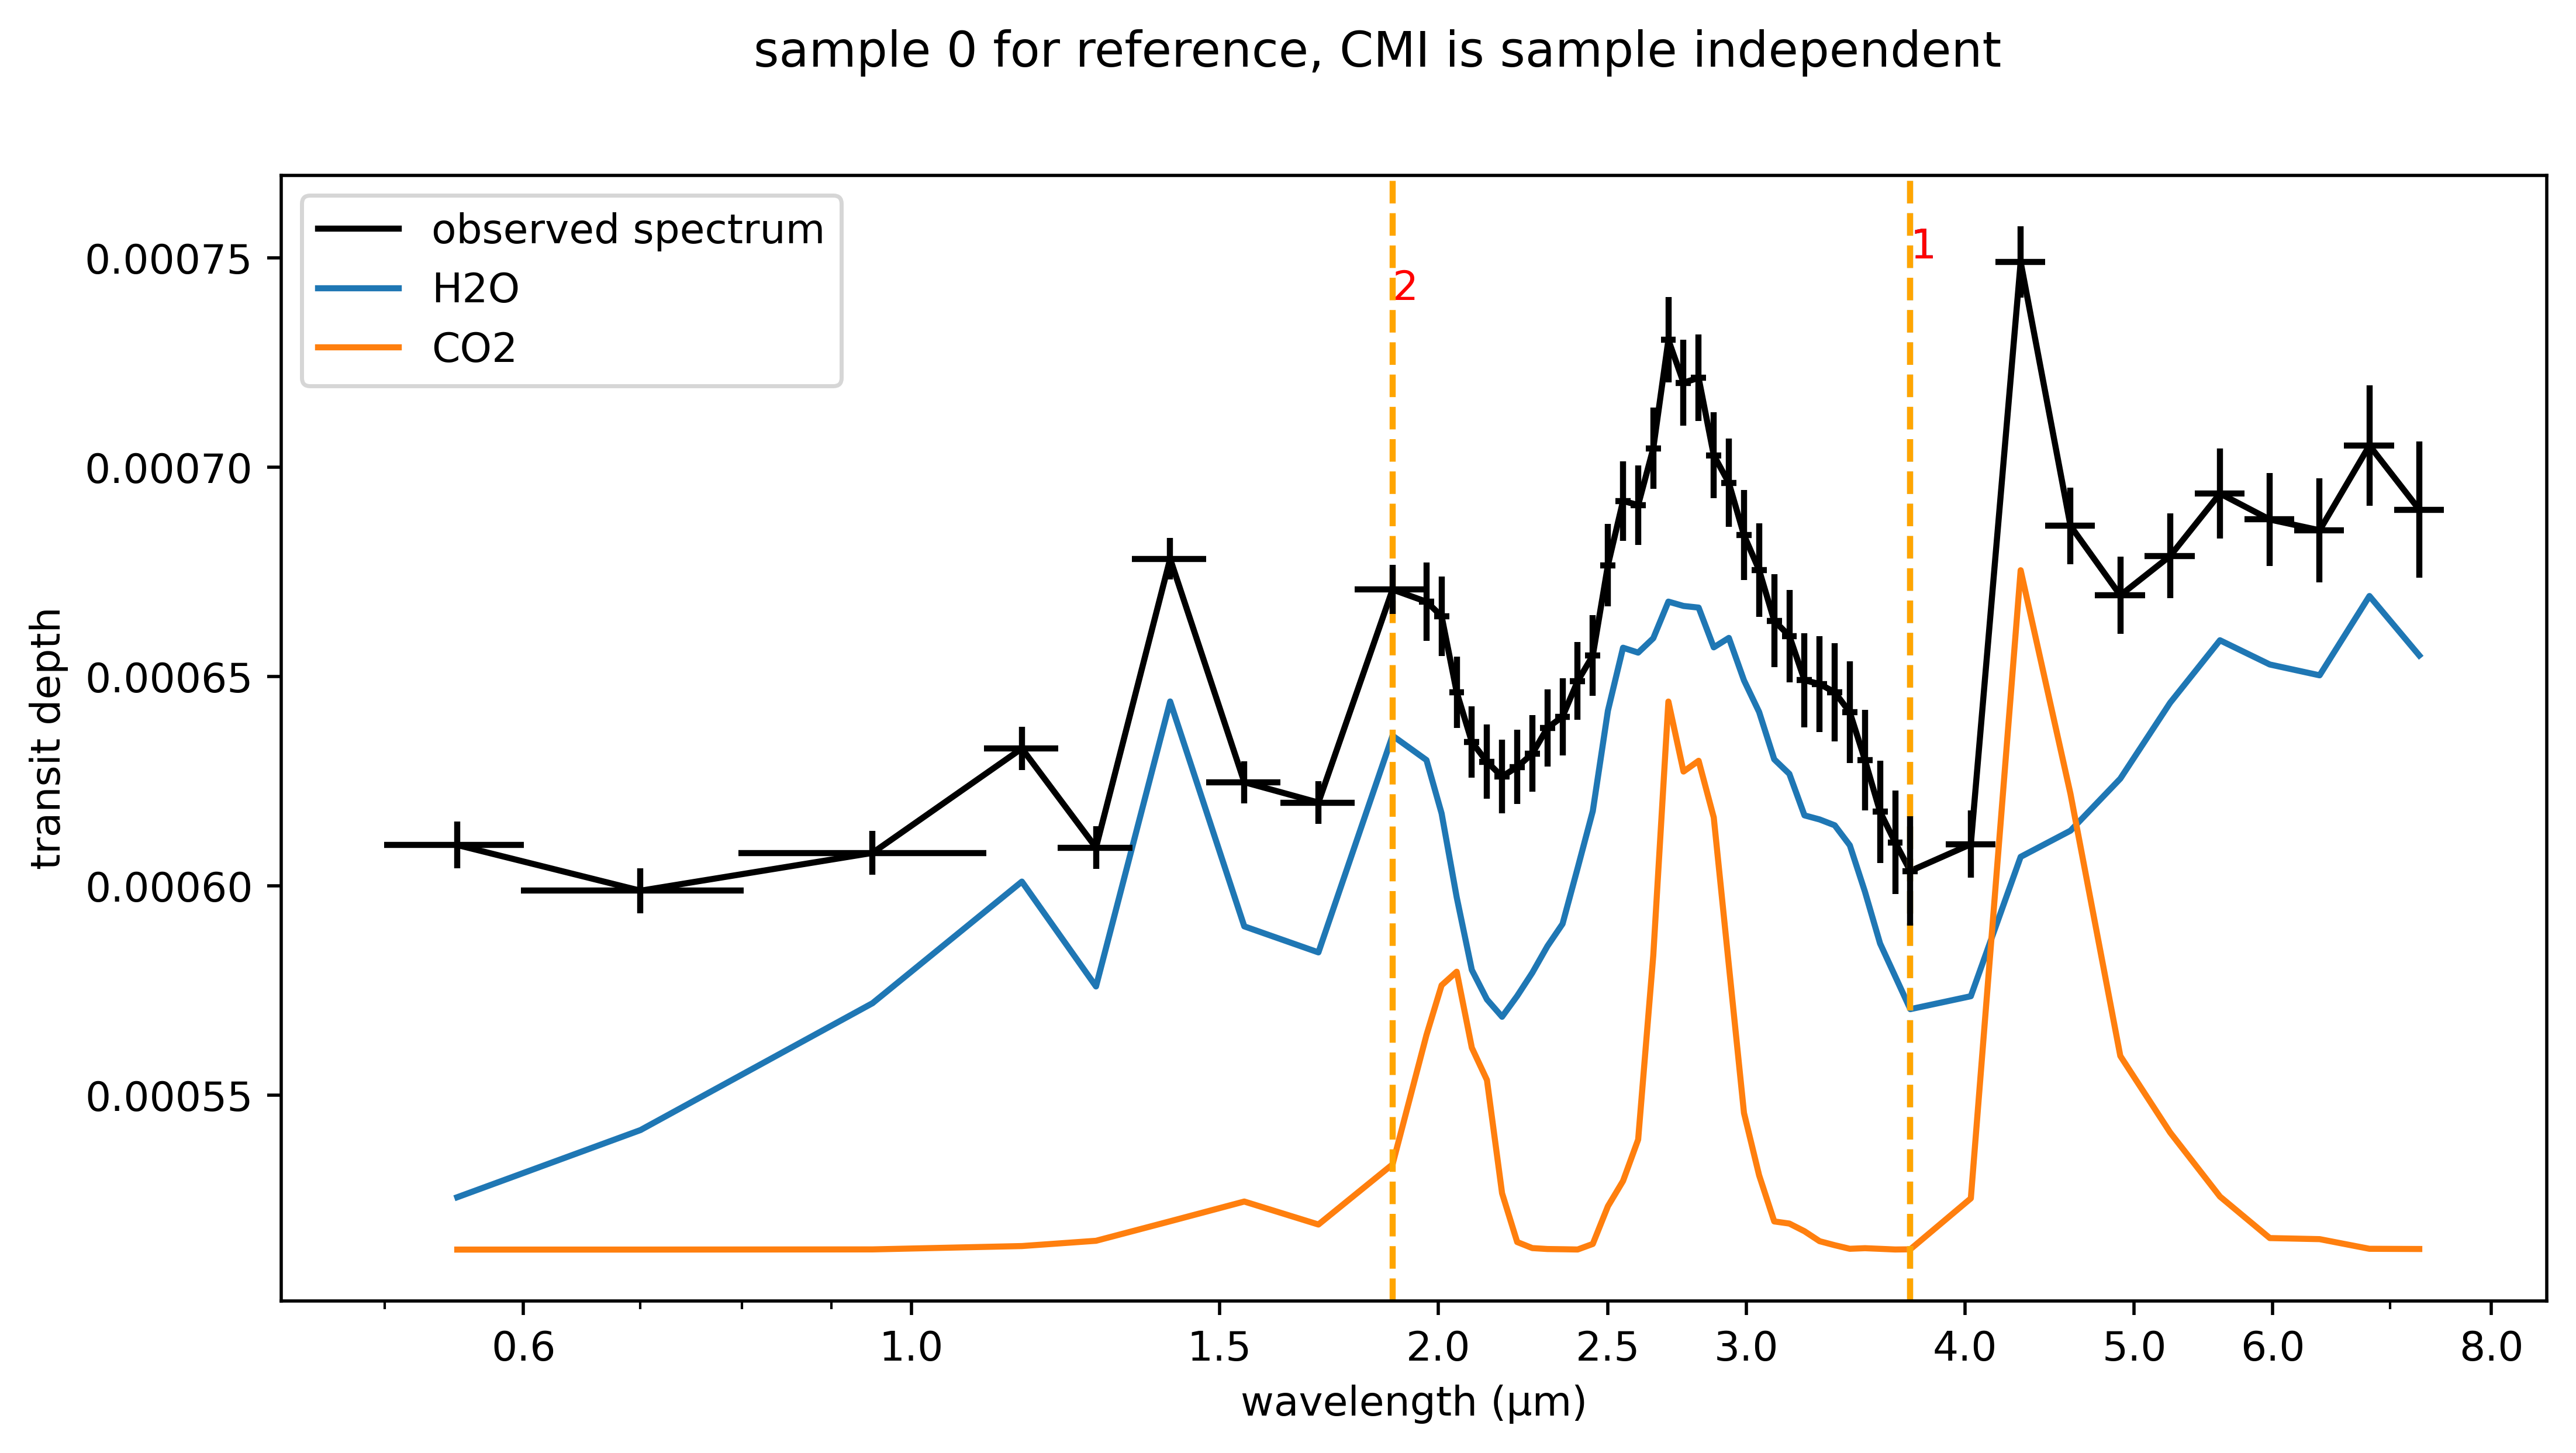

In [102]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=500)




ax.plot(ds['wavelength'],test_spectra[i,:], "k-", label='observed spectrum')


ax.plot(ds['wavelength'], test_h2o[i,:], '-',label='H2O')
ax.plot(ds['wavelength'], test_co2[i,:], '-',label='CO2')

h2o = best_wavelength_choice[:,0][np.where(best_wavelength_choice[:,0]!=0)].astype(int)
co2 = best_wavelength_choice[:,1][np.where(best_wavelength_choice[:,1]!=0)].astype(int)

for val, h in enumerate(h2o):
    ax.axvline(ds['wavelength'].isel(wavelength=h), color='lightblue', linestyle='--')
    ax.text(ds['wavelength'].isel(wavelength=h), 0.00075-0.00001*val, f'{val+1}', rotation=0, color='navy')
for val, c in enumerate(co2):
    ax.axvline(ds['wavelength'].isel(wavelength=c), color='orange', linestyle='--')
    ax.text(ds['wavelength'].isel(wavelength=c), 0.00075-0.00001*val, f'{val+1}', rotation=0, color='red')

ax.errorbar(ds['wavelength'],test_spectra[i,:],xerr=ds['bin_width']/2, yerr=test_noise[i,:], fmt='none', color='black', )
# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')
# ax_shap.plot(ds['wavelength'], joint_shap_values[i], 'k-',label='SHAP total')


ax.set_xlabel('wavelength (µm)')
ax.set_ylabel('transit depth')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i} for reference, CMI is sample independent')
ax.legend()

CMI-selected wavelength indices: [ 0 41]
Mean MSE for CMI-selected bins: 0.0823455873039001
Permutation test p-value: 1.0


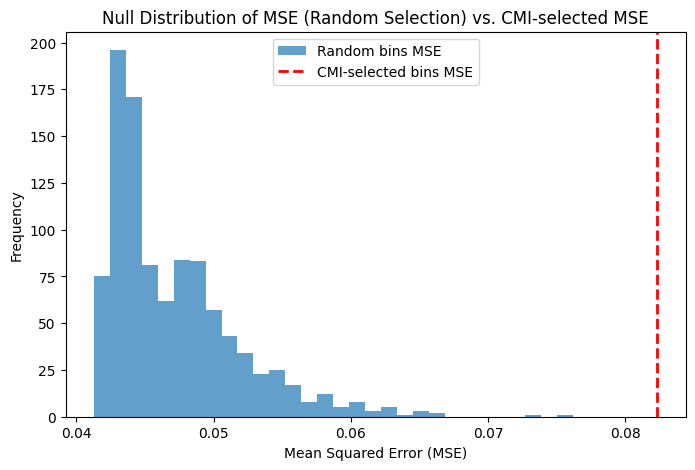

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Assume:
# - X is your feature matrix with shape (n_samples, n_wavelengths)
X = test_spectra_normalised
# - y is your target vector for one molecule, shape (n_samples,)
y = test_labels_normalised[:, 0]  # For H2O, change to 1 for CO2 as needed.
# - best_wavelength_choice is an array of shape (n_wavelengths, 2) from your CMI analysis.
#   Here, we'll focus on one label (e.g., label_idx = 0 for H2O).
# - k is the number of bins you want to test (e.g., top 10 bins).


label_idx = 0  # For H2O, change to 1 for CO2 as needed.
k = 30  # Number of top bins to select from your CMI-based analysis

# Extract the top-k wavelength indices from your best_wavelength_choice for the chosen label.
# It is important to ensure these indices are unique and valid.
selected_indices = np.unique(best_wavelength_choice[:k, label_idx].astype(int))
print("CMI-selected wavelength indices:", selected_indices)

# Define the regression model (you may use any other model as appropriate)
rmodel = LinearRegression()

# Evaluate performance (using 5-fold cross validation) on the selected bins.
# We'll use negative MSE so that higher scores indicate better performance.
scores_selected = cross_val_score(rmodel, X[:, selected_indices], y,
                                  cv=5, scoring='neg_mean_squared_error')
mse_selected = -np.mean(scores_selected)
print("Mean MSE for CMI-selected bins:", mse_selected)

# Number of random trials for the permutation test
n_trials = 1000
mse_random = []

n_wavelengths = X.shape[1]
for i in range(n_trials):
    # Randomly select k bins (ensuring no replacement)
    random_indices = np.sort(np.random.choice(n_wavelengths, k, replace=False))
    scores_rand = cross_val_score(rmodel, X[:, random_indices], y,
                                  cv=5, scoring='neg_mean_squared_error')
    mse_rand = -np.mean(scores_rand)
    mse_random.append(mse_rand)

mse_random = np.array(mse_random)

# Compute p-value: proportion of random trials that achieve equal or lower MSE (better performance)
p_value = (np.sum(mse_random <= mse_selected) + 1) / (n_trials + 1)
print("Permutation test p-value:", p_value)

# Plot the null distribution of random MSEs vs. the CMI-selected MSE
plt.figure(figsize=(8, 5))
plt.hist(mse_random, bins=30, alpha=0.7, label='Random bins MSE')
plt.axvline(mse_selected, color='red', linestyle='dashed', linewidth=2,
            label='CMI-selected bins MSE')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Null Distribution of MSE (Random Selection) vs. CMI-selected MSE')
plt.legend()
plt.show()


Loss (MSE) for CMI-selected bins: 40.332027435302734
Permutation test p-value: 0.8901098901098901


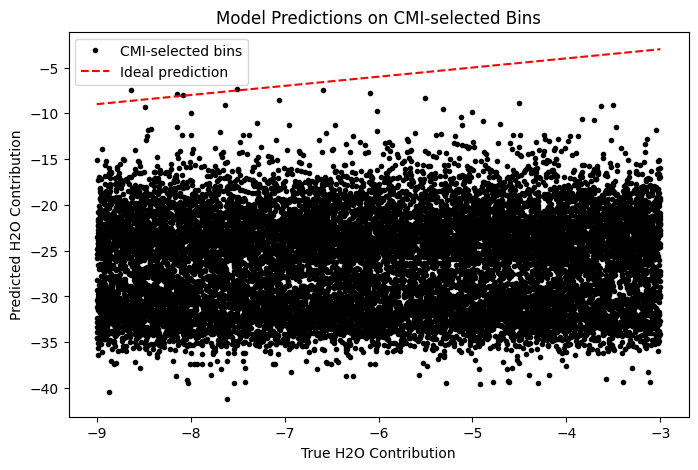

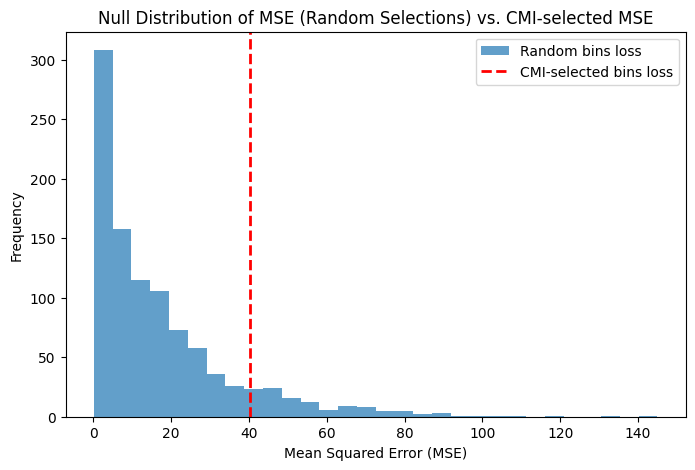

In [104]:
def evaluate_model_on_subset(model, X, y, selected_indices):
    """
    Create an input array where only the features at selected_indices are retained 
    and the rest are set to zero, then evaluate the model using MSELoss.
    
    Parameters:
      model: trained neural network (NetA)
      X: numpy array of shape (n_samples, 52)
      y: numpy array of shape (n_samples, target_dim)
      selected_indices: list or array of feature indices to use
      
    Returns:
      loss: MSE loss value (float)
    """
    # Create a masked version of the input: fill with zeros, then place original values for selected bins
    X_subset = np.zeros_like(X)
    X_subset[:, selected_indices] = X[:, selected_indices]
    # X_subset = X # --TEST, uses all bins as standard
    # Convert data to tensors
    X_tensor = torch.Tensor(X_subset)
    y_tensor = torch.Tensor(y)
    
    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor)
        loss = criterion(predictions, y_tensor)
        unnormed_predictions = labels_normaliser.denormalise(predictions.numpy())

    return loss.item(), unnormed_predictions

# --- Evaluation on the CMI-selected bins ---

# Example: these are the bins selected by your CMI analysis
cmi_selected_indices = np.array([0, 1, 7, 10, 11, 32, 36, 46, 48])
loss_selected, pred_cmi = evaluate_model_on_subset(model, test_spectra_normalised, test_labels_normalised, cmi_selected_indices)
print("Loss (MSE) for CMI-selected bins:", loss_selected)

# --- Permutation Test Using the Pre-trained Model ---

n_trials = 1000
loss_random = []
n_features = test_spectra_normalised.shape[1]
k = len(cmi_selected_indices)
pred_rand_store = np.zeros((n_trials, test_labels_normalised.shape[0], test_labels_normalised.shape[1]))

for i in range(n_trials):
    # Randomly select k unique bins
    random_indices = np.sort(np.random.choice(n_features, k, replace=False))
    loss_rand, pred_rand = evaluate_model_on_subset(model, test_spectra_normalised, test_labels_normalised, random_indices)
    loss_random.append(loss_rand)
    pred_rand_store[i] = pred_rand

loss_random = np.array(loss_random)

# Compute p-value: proportion of random trials that achieve loss equal or lower than the CMI selection.
p_value = (np.sum(loss_random <= loss_selected) + 1) / (n_trials + 1)
print("Permutation test p-value:", p_value)

# --- Plot the Predictions ---

plt.figure(figsize=(8, 5))
plt.plot(test_labels[:, 0], pred_cmi[:, 0], '.k', label='CMI-selected bins')
corners = [test_labels[:, 0].min(), test_labels[:, 0].max()]
plt.plot(corners, corners, 'r--', label='Ideal prediction')

plt.xlabel('True H2O Contribution')
plt.ylabel('Predicted H2O Contribution')
plt.title('Model Predictions on CMI-selected Bins')
plt.legend()
plt.show()



# --- Plot the Null Distribution ---
plt.figure(figsize=(8, 5))
plt.hist(loss_random, bins=30, alpha=0.7, label='Random bins loss')
plt.axvline(loss_selected, color='red', linestyle='dashed', linewidth=2,
            label='CMI-selected bins loss')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Null Distribution of MSE (Random Selections) vs. CMI-selected MSE')
plt.legend()
plt.show()


## pertubation sensitivity


In [105]:
# # Assume test_spectra and observation_uncertainty are already defined with shapes (n_samples, 52)
# n_samples, n_wavelengths = test_spectra.shape  # n_wavelengths should be 52
# n_replicates = 5

# # Preallocate the output array with shape:
# # (n_samples, 52 (spectrum features), 52 (perturbed wavelength index), 100 (replicates))
# noisy_spectra = np.empty((n_samples, n_wavelengths, n_wavelengths, n_replicates))

# # Reshape test_spectra for broadcasting to (n_samples, 52, 52, 100)
# base_spectra_expanded = np.expand_dims(test_spectra, axis=(2, 3))
# base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_wavelengths, n_replicates))

# # Generate noise for all perturbations and replicates simultaneously
# noise = np.random.normal(
#     loc=0.0,
#     scale=np.expand_dims(test_noise, axis=(2, 3)),
#     size=(n_samples, n_wavelengths, n_wavelengths, n_replicates)
# )

# # Add noise only to the specific wavelength index being perturbed
# perturb_mask = np.eye(n_wavelengths, dtype=bool)[np.newaxis, :, :, np.newaxis]  # Shape (1, 52, 52, 1)
# noisy_spectra = base_spectra_expanded + (noise * perturb_mask)

# print("Noisy spectra generated with shape:", noisy_spectra.shape)

In [106]:
# plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, 48])
# plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].min(axis=2).min(axis=1), 'k--',label='min')
# plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].max(axis=2).max(axis=1), "k--",label='max')

# plt.xlabel('wavelength')
# plt.ylabel('transit depth')

# axs = plt.gca()
# axs.set_xscale('log')
# axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
# axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# plt.show()

In [107]:
# # Convert noisy_spectra to a PyTorch tensor
# noisy_spectra_tensor = torch.Tensor(noisy_spectra)  # Shape: (n_samples, 52, 52, 100)

# # Reshape to a 2D tensor for batch processing
# # New shape: (n_samples * 52 * 100, 52)
# n_samples, n_wavelengths, _, n_replicates = noisy_spectra_tensor.shape
# noisy_spectra_flat = noisy_spectra_tensor.permute(0, 3, 2, 1).reshape(-1, n_wavelengths)

In [108]:
# # Pass through the model
# with torch.no_grad():
#     predictions_flat = model(noisy_spectra_flat)  # Shape: (n_samples * 52 * 100, 2)

In [109]:
# predictions_flat = labels_normaliser.denormalise(predictions_flat)
# # Reshape back to the desired shape
# # New shape: (n_samples, 2 (labels), 52 (perturbed wavelength), 100 (replicates))
# predictions_n = predictions_flat.view(n_samples, n_replicates, n_wavelengths, -1).permute(0, 3, 2, 1)



# print("Predictions shape:", predictions_n.shape)  # Should be (n_samples, 2, 52, 100)


In [110]:
# i = 0
# all_species = ds.species.values[1:]

# fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ax_pert = ax[1]
# ax = ax[0]

# ax.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')


# ax.plot(
#     ds['wavelength'],
# ds['contributions'].sel(sample=i,
#                     species=['H2O', 'CO2',]
#                     ).values.T, label=['H2O', 'CO2', ])


# ax.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

# # ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

# ax_pert.plot(  ds['wavelength'] ,predictions_n[0, 0, :].std(axis=1), '-',label=label_names[0])
# ax_pert.plot(  ds['wavelength'] ,predictions_n[0, 1, :].std(axis=1), '-',label=label_names[1])


# ax_pert.set_xlabel('wavelength')
# ax.set_ylabel('transit depth')
# ax_pert.set_ylabel('sensitivity to pertubation')

# ax.set_xscale('log')
# ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
# ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# fig.suptitle(f'sample {i}')
# ax_pert.legend(loc='upper left')
# ax.legend()